In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

CNN, 스트라이드와 패딩 : https://tensorflow.blog/a-guide-to-convolution-arithmetic-for-deep-learning/

# 합성곱 층

In [2]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

china.shape, images.shape

((427, 640, 3), (2, 427, 640, 3))

In [4]:
batch_size, height, width, channels = images.shape

#7*7 필터(3채널) 2개 생성
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)

filters.shape, filters

((7, 7, 3, 2),
 array([[[[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        [[[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]]],
 
 
        [[[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [0.,

In [6]:
filters[:, 3, :, 0] = 1 #수직선(3번 열값 전체를 1)
filters[3:, :, :, 1] = 1 #수평선(3번 행 값 전체를 1)

filters

array([[[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 

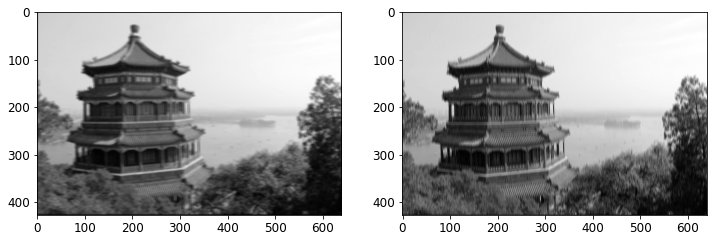

In [11]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") #VALID : 패딩 없음, SAME : 제로패딩(strides=1의 경우 입력과 출력이 동일)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(outputs[0, :, :, 1], cmap="gray") #첫번째 이미지의 두 번째 특성 맵 그리기(수평선 필터)

plt.subplot(122)
plt.imshow(outputs[0, :, :, 0], cmap="gray") #첫번째 이미지의 첫 번째 특성 맵 그리기(수직선 필터)
plt.show()

In [ ]:
#Conv2D 층 사용
#3*3크기의 필터 32개
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

# 풀링 층

계산량과 메모리 사용량, (과대적합의 위험을 줄여주는)파라미터 수를 줄이기 위해 입력 이미지의 축소본을 만드는 것

In [13]:
#2*2 커널을 사용해 최대 풀링 층, 기본적으로 valid패딩(패딩 없음)
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [17]:
def crop(images):
    return images[150:220, 130:250]

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


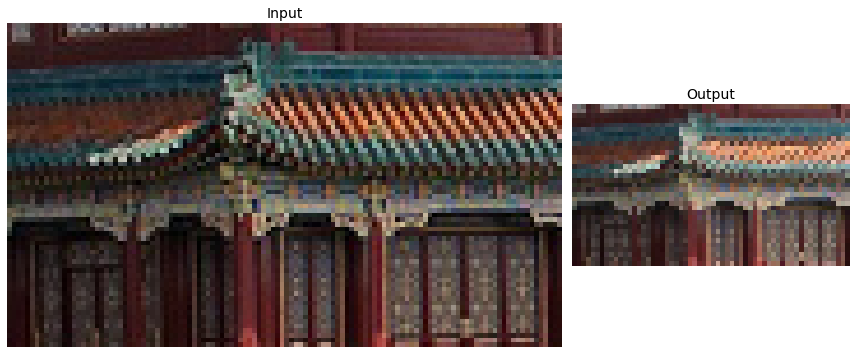

In [18]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

깊이방향 최대 풀링을 사용한 CNN은 다양한 특성에 대한 불변성 학습 가능(ex: 같은 손글씨가 여러방향으로 회전되어 있는 것)

케라스는 깊이방향 풀링층이 없음

텐서플로우 저수준 딥러닝 API 사용 가능

In [24]:
cropped_images[0].shape

(70, 120, 3)

In [15]:
ouput = tf.nn.max_pool(images,
                      ksize=(1, 1, 1, 3), #커널 크기 - 배치 1, 높이 1, 너비차원 1, 깊이 3
                      strides=(1, 1, 1, 3), #스트라이드 크기
                      padding="VALID")

In [23]:
#케라스의 모델 층으로 만들기
depth_pool = keras.layers.Lambda(
    lambda x:tf.nn.max_pool(x,
                      ksize=(1, 1, 1, 3), #커널 크기 - 배치 1, 높이 1, 너비차원 1, 깊이 3
                      strides=(1, 1, 1, 3), #스트라이드 크기
                      padding="VALID")
)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [19]:
#케라스 사용자 정의 층 만들기

class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [20]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [26]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

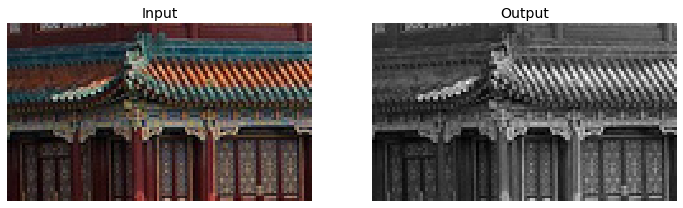

In [27]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

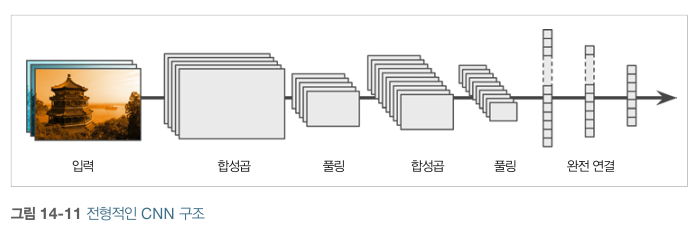

# CNN으로 패션 MNIST 문제 해결

In [30]:
a = np.arange(9)

a[3:], a[:-3], a[-3:] #앞의 3개를 빼느냐 뒤의 3개를 빼느냐의 차이, 뒤에서 3번째 부터 자르기

(array([3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5]), array([6, 7, 8]))

In [31]:
#데이터 로드

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[-5000:], X_train_full[:-5000] #뒤에서 5000번째 부터 자르기, 뒤의 5000개를 제외하고 자르기
y_valid, y_train = y_train_full[-5000:], y_train_full[:-5000]

X_mean = X_train.mean(axis=0, keepdims=True) #맨 앞의 행 차원을 지키기 위해서 keepdims 사용
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train.shape, X_mean.shape, X_std.shape

((55000, 28, 28), (1, 28, 28), (1, 28, 28))

In [32]:
#데이터 정규화
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis] #컬러 채널 차원 추가(그레이 스케일)
X_valid = X_valid[..., np.newaxis] #컬러 채널 차원 추가
X_test = X_test[..., np.newaxis]   #컬러 채널 차원 추가

X_train.shape

(55000, 28, 28, 1)

In [36]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                       kernel_size=3, activation="relu", padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), #7*7필터, 하나의 컬러채널이므로 28*28*1
    keras.layers.MaxPooling2D(pool_size=2),  
    DefaultConv2D(filters=128),              #CNN이 출력층으로 갈수록 필터 개수가 늘어남 : 저수준 특성을 모아서 고수준 특성을 만듬
    DefaultConv2D(filters=128),              #풀링층 다음에 필터 개수를 2배로 늘리는 게 일반적
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),              
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),                  #배열 1차원으로 펼치기
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),              #과대적합을 줄이기 위해 드롭아웃
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="nadam",
             metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

score, y_pred

Epoch 1/10
1719/1719 [==============================] - 172s 100ms/step - loss: 0.7079 - accuracy: 0.7550 - val_loss: 0.3834 - val_accuracy: 0.8588
Epoch 2/10
1719/1719 [==============================] - 176s 102ms/step - loss: 0.4144 - accuracy: 0.8620 - val_loss: 0.3477 - val_accuracy: 0.8778
Epoch 3/10
1719/1719 [==============================] - 174s 101ms/step - loss: 0.3574 - accuracy: 0.8796 - val_loss: 0.2975 - val_accuracy: 0.8926
Epoch 4/10
1719/1719 [==============================] - 178s 103ms/step - loss: 0.3259 - accuracy: 0.8905 - val_loss: 0.2950 - val_accuracy: 0.8920
Epoch 5/10
1719/1719 [==============================] - 175s 102ms/step - loss: 0.3031 - accuracy: 0.8971 - val_loss: 0.2779 - val_accuracy: 0.9054
Epoch 6/10
1719/1719 [==============================] - 173s 100ms/step - loss: 0.2925 - accuracy: 0.9021 - val_loss: 0.2854 - val_accuracy: 0.9016
Epoch 7/10
1719/1719 [==============================] - 174s 101ms/step - loss: 0.2747 - accuracy: 0.9066 - val_

([0.2926284074783325, 0.9034000039100647],
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.92818646e-14, 0.00000000e+00, 6.04714634e-09,
         0.00000000e+00, 1.00000000e+00],
        [2.04277715e-08, 1.55345946e-18, 9.99922633e-01, 2.06066260e-14,
         4.54894825e-06, 2.45128345e-25, 7.28449741e-05, 1.89112973e-32,
         1.54061939e-16, 6.33810882e-28],
        [2.18321117e-36, 1.00000000e+00, 3.92020335e-35, 6.89323299e-26,
         1.36988497e-32, 0.00000000e+00, 1.36328063e-31, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 9.79301748e-30,
         9.36243601e-38, 0.00000000e+00, 7.42780703e-36, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [4.13339958e-03, 5.98501970e-10, 2.77918205e-03, 1.81316951e-04,
         8.64616036e-03, 1.76458254e-13, 9.84259903e-01, 9.96637855e-15,
         1.40435814e-08, 1.51165947e-15],
        [1.376021

# ResNet-34 CNN 구현하기

In [39]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

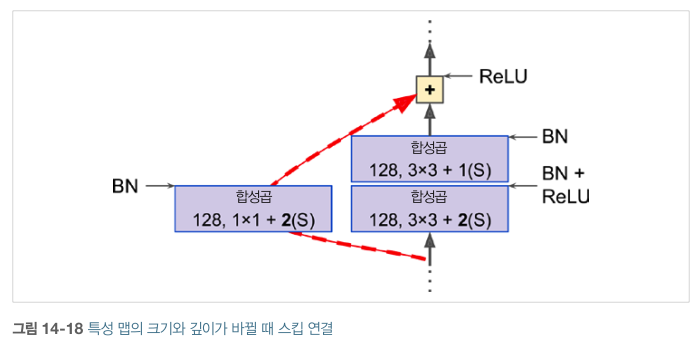

main_layers가 오른쪽, skip_layers가 왼쪽

In [40]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

# 케라스에서 제공하는 사전훈련된 모델 사용하기

GoogLeNet, ResNet 같은 표준 모델을 이미 사전 훈련된 모델로 제공됨

In [42]:
#사전 훈련된 ResNet-50 모델 로드하기

model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 8s 0us/step


In [43]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [44]:
#입력 값이 224, 224, 3 이므로 샘플 이미지를 변환

images_resized = tf.image.resize(images, [224, 224]) #가로세로 비율 유지 하지 않음. tf.image.crop_and_resize 사용가능

images.shape, images_resized.shape

((2, 427, 640, 3), TensorShape([2, 224, 224, 3]))

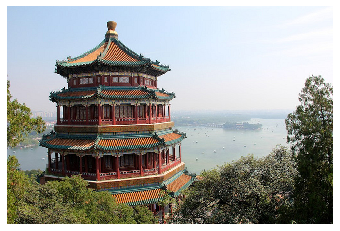

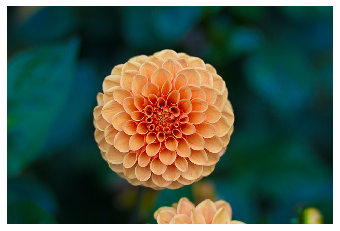

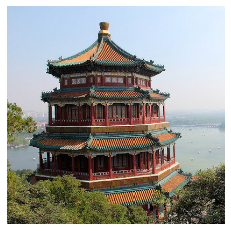

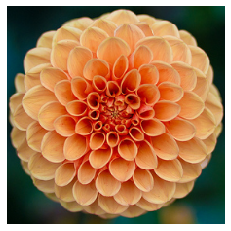

In [48]:
#원래 이미지
plot_color_image(images[0])
plt.show()
plot_color_image(images[1])
plt.show()
#조정한 이미지

china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [49]:
#사전 훈련된 모델은 입력을 전처리 해주는 preprocess_input() 제공

#원본 이미지 값으로 바꾸어 전처리 수행
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [50]:
y_proba = model.predict(inputs)

In [53]:
y_proba, y_proba.shape

#예측 값은 행이 하나의 이미지에 대한 예측이고, 각 행은 1000개의 클래스에 대한 확률

(array([[7.3527966e-09, 2.1549987e-08, 7.4667206e-09, ..., 1.7053288e-09,
         1.1168152e-07, 3.3814477e-08],
        [2.3453687e-07, 7.0248625e-06, 4.0475322e-07, ..., 5.3985503e-05,
         3.6657228e-05, 1.3363847e-04]], dtype=float32),
 (2, 1000))

In [51]:
top_K = keras.applications.resnet50.decode_predictions(y_proba, top=3)
for image_index in range(len(images)):
    print(f"이미지 #{image_index}")
    for class_id, name, y_proba_ in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba_ * 100))
    print()

이미지 #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

이미지 #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



# 사전훈련된 모델을 사용한 전이학습

이미지넷에 없는 이미지 클래스를 감지하는 이미지 분류기가 필요하다면.

사전훈련된 모델을 사용해 전이 학습 수행

예를 들어 사전훈련된 Xception모델로 꽃 이미지 분류

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [3]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

dataset_size, class_names, n_classes

(3670, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

In [4]:
# 훈련 세트만 있고, 테스트나 검증 세트가 없음

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

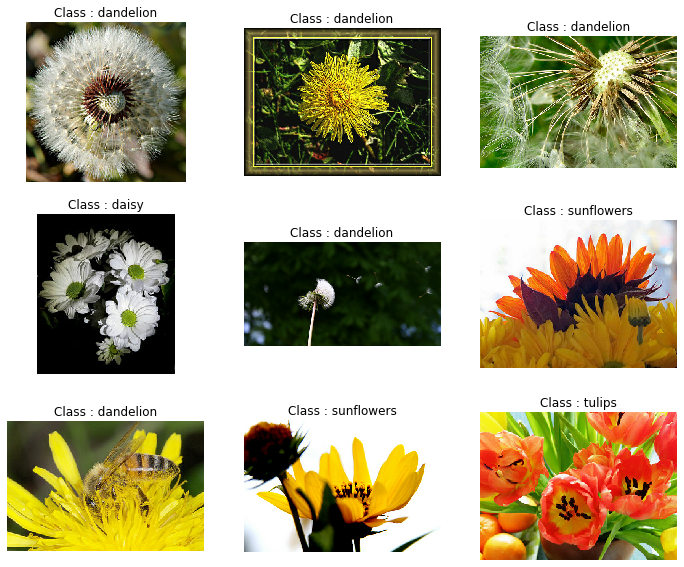

In [5]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class : {class_names[label]}")
    plt.axis("off")          
    
plt.show()

In [6]:
#기본 전처리

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [7]:
#좀 더 전처리 수행하기(랜덤하게 이미지를 자를 위치를 선ㅌ액)

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image) #랜덤하게 자를 위치를 선택하고
        cropped_image = tf.image.random_flip_left_right(cropped_image) #랜덤하게 이미지 수평으로 뒤집기
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()

In [8]:
from functools import partial

train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

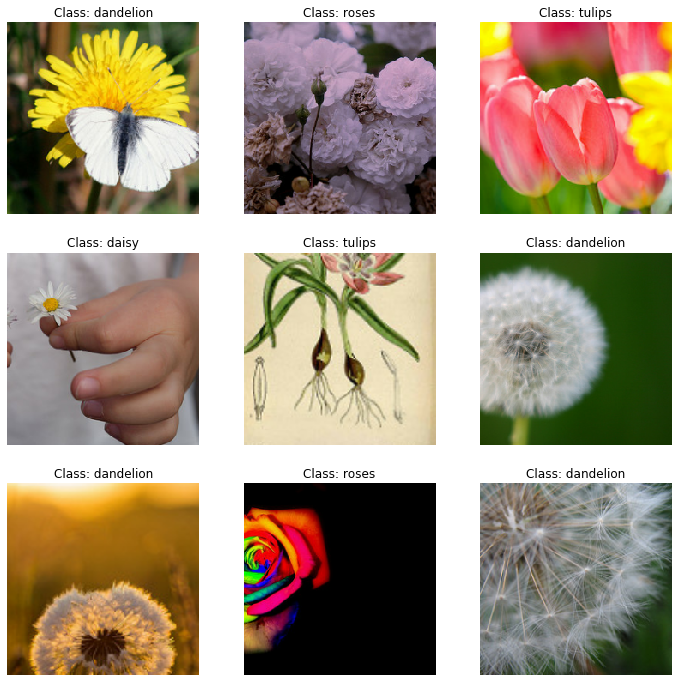

In [9]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

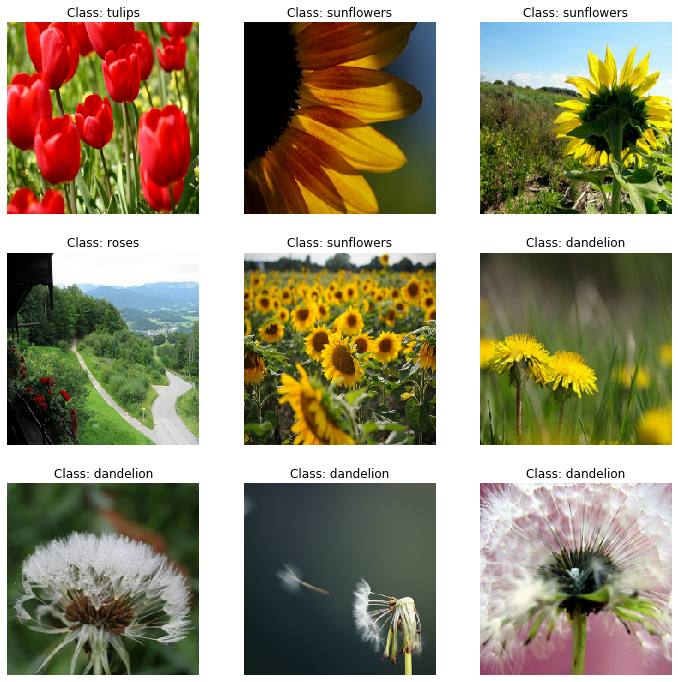

In [10]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [11]:
#xception 모델 불러오기
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False) #네트워크 최상층에 해당하는 전역 풀링층과 밀집 출력층 제외

avg = keras.layers.GlobalAveragePooling2D()(base_model.output) #새로운 전역 평균 풀링 층 추가
output = keras.layers.Dense(n_classes, activation="softmax")(avg) #클래스마다 하나의 유닛과 소프트맥스 활성화 함수를 가지는 밀집 출력층
model = keras.models.Model(inputs=base_model.input, outputs=output) #케라스 모델 객체 생성

83689472/83683744 [==============================] - 14s 0us/step


In [13]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

아래의 코드는 GPU에서 실행하는 게 훨씬 빠른데

현재 Docker를 통한 GPU 지원은 리눅스 기반에서만 지원되는 듯.

그렇다면 2004업데이트를 해서 WSL2에서 실행을 해봐야 할 것 같은데

-----------------하지만!! 현재 WSL2의 프리뷰 버전에서만 GPU사용 가능. 윈도우 개발자 프로그램 가입해야 함.

https://www.tensorflow.org/install/docker?hl=ko

https://ubuntu.com/blog/getting-started-with-cuda-on-ubuntu-on-wsl-2

https://developer.nvidia.com/blog/announcing-cuda-on-windows-subsystem-for-linux-2/

2600X(6코어 12스레드)에서 한 에포크에 169초씩 걸림 -> i5-4120M(2코어 4스레드, 2.6GHz) + 950M에서 한 에포크에 69초

3.47GiB를 할당하려했으나 950M의 메모리가 2GB에 불과해서 다음과 같은 에러 메세지 발생

W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

### 2600X + 1080

한 에포크에 12초!

In [12]:
#초기 학습에서는 사전 훈련된 층을 제외하고(가중치 동결) 새로 추가된 층을 훈련
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
86/86 [==============================] - 17s 200ms/step - loss: 0.6399 - accuracy: 0.7827 - val_loss: 1.6158 - val_accuracy: 0.7132
Epoch 2/5
86/86 [==============================] - 12s 134ms/step - loss: 0.3973 - accuracy: 0.8699 - val_loss: 1.4214 - val_accuracy: 0.7482
Epoch 3/5
86/86 [==============================] - 12s 134ms/step - loss: 0.3080 - accuracy: 0.8972 - val_loss: 1.3028 - val_accuracy: 0.7463
Epoch 4/5
86/86 [==============================] - 12s 134ms/step - loss: 0.2580 - accuracy: 0.9110 - val_loss: 1.2194 - val_accuracy: 0.7574
Epoch 5/5
86/86 [==============================] - 12s 134ms/step - loss: 0.2324 - accuracy: 0.9230 - val_loss: 1.2991 - val_accuracy: 0.7445


In [13]:
#현재 텐서플로우에 활성화된 GPU 목록
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

이번에는 할당하려는 데 GPU 메모리 부족 오류 발생. 배치 사이즈를 줄여야 할 것 같다.

ResourceExhaustedError:  OOM when allocating tensor with shape[728,728,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block4_sepconv2/separable_conv2d (defined at <ipython-input-19-4a4e05dd9c77>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_33258]

Function call stack:
distributed_function


### 메모리 부족이 발생한 이유

위에서 배치 사이즈 32로 훈련할 때는 사전 훈련된 Xception 모델에서 제거된 최상층을 제외하고는 모두 훈련을 하지 않도록 설정했으므로
메모리 할당량이 적었던 것.

그런데 아래의 훈련에서는 전체 네트워트를 훈련 시키므로 훈련에 필요한 메모리량이 급증하여 배치 사이즈를 1/4로 줄여야 실행 가능했다.

950M의 메모리가 2GB밖에 되지 않아서 발생하는 현상

### 2600X + 1080으로 다시 실행

배치 사이즈 32로

In [14]:
from functools import partial

batch_size = 32 #배치 사이즈 1/4으로

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

### 시간이 너무 오래 걸리므로 중단했지만, 이전 학습에 이어서 정확도가 확 향상된 걸 확인할 수 있다.

### 2600X + 1080으로 재실행

메모리 부족 에러는 여전히 발생하지만, GPU 사용률이 90~100%를 오간다.

각 에포크마다 49초 정도

너무 오래걸리니까 중간에 끊음.

In [15]:
#최상층의 훈련이 어느정도 진행되면 사전훈련된 층의 동결을 해제하고 다시 훈련

for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, #사전훈련된 가중치의 훼손을 막기 위해 훨씬 작은 학습률 사용(0.2 -> 0.01)
                                 nesterov=True, decay=0.001)  
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, #층을 동결하거나 해제할 때 다시 컴파일 필요
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Train for 86 steps, validate for 17 steps
Epoch 1/40
86/86 [==============================] - 80s 925ms/step - loss: 0.2547 - accuracy: 0.9153 - val_loss: 0.5946 - val_accuracy: 0.8640
Epoch 2/40
86/86 [==============================] - 52s 602ms/step - loss: 0.1013 - accuracy: 0.9688 - val_loss: 0.3684 - val_accuracy: 0.8824
Epoch 3/40
86/86 [==============================] - 49s 572ms/step - loss: 0.0712 - accuracy: 0.9760 - val_loss: 0.2831 - val_accuracy: 0.9136
Epoch 4/40
86/86 [==============================] - 49s 571ms/step - loss: 0.0339 - accuracy: 0.9869 - val_loss: 0.2479 - val_accuracy: 0.9173
Epoch 5/40
86/86 [==============================] - 48s 562ms/step - loss: 0.0379 - accuracy: 0.9887 - val_loss: 0.3558 - val_accuracy: 0.8971
Epoch 6/40
86/86 [==============================] - 48s 562ms/step - loss: 0.0292 - accuracy: 0.9920 - val_loss: 0.3129 - val_accuracy: 0.9062
Epoch 7/40
62/86 [====================>.........] - ETA: 13s - loss: 0.0244 - accuracy: 0.9913

KeyboardInterrupt: 

# 분류와 위치 추정

물체 주위에 바운딩 박스를 예측하기 위해, 

전역 풀링 층 위에 네 개의 유닛(물체 중심의 수평, 수직 좌표와 높이, 너비)을 가진 두번째 밀집 출력 층읅 추가하고 MSE 손실 사용

In [7]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)    #네트워크 최상층에 해당하는 전역 풀링층과 밀집 출력층 제외
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)           #새로운 전역 평균 풀링 층 추가
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)  #클래스 개수 만큼 분류
loc_output = keras.layers.Dense(4)(avg)                                  #바운딩 박스 출력
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)

model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

하지만 꽃 데이터셋은 꽃 주위에 바운딩박스 가 없어서 직접 추가해야 함.

바운딩 박스가 준비되었다면, 클래스 레이블, 바운딩 박스와 함께 전처리된 원소의 데이터 셋 만들어야 함

(images, (class_labels, bounding_boxes)) 형태의 튜플

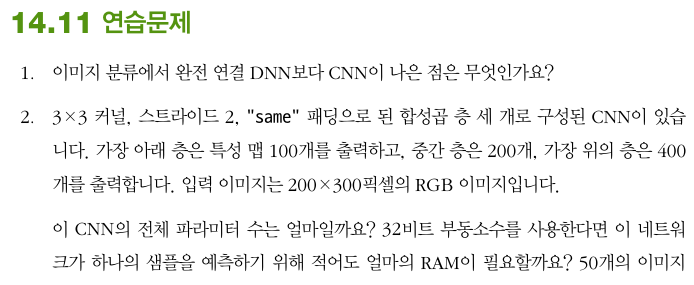
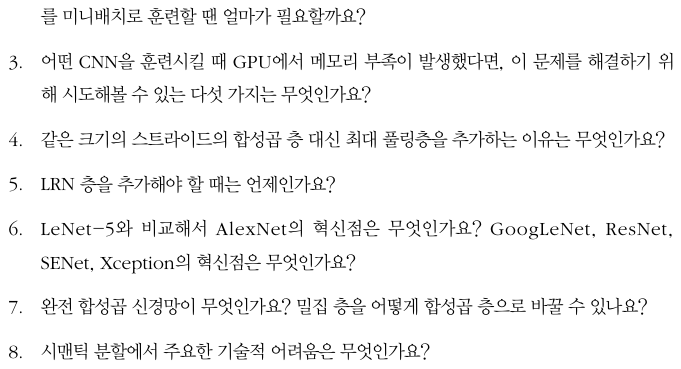

1.  
   - 연속된 층이 부분적으로 연결되어 있고 많은 가중치를 재사용하므로 완전 연결 DNN에 비해 적은 파라미터를 가지며, 훈련속도가 빠르고 과대적합의 위험이 적다
   - 어떤 특성을 감지할 수 있는 커널을 학습하면 이미지의 어느 위치라고 감지 가능
   - 하위층은 이미지의 작은 영역의 특성을 구별, 상위층은 저수준 특성을 더 큰 특성으로 연결
   
   
2. ???


3. 
   - 미니배치 크기 줄이기
   - 하나 이상의 층에서 스트라이드 크기를 늘려서 차원 감소
   - 하나 이상의 층 제거
   - 32비트 대신 16비트 부동소수 사용
   - 여러 장치에 CNN분산
   
   
4. 최대 풀링층은 파라미터를 전혀 가지고 있지 않음


5. 가장 강하게 활성화되는 뉴련이 이웃한 특성맵의 동일한 위치에 있는 뉴련을 억제, 넓은 범위의 특성을 탐색하도록 강제. 일반적으로 하위층에서 사용


6. ALexNet
   - 더 크고 깊으며
   - 합성곱층 위에 풀링층을 두지 않고 합성곱층으로만 쌓아 올림
   
   GoogLeNet
   - 더 적은 파라미터로 기존CNN 구조보다 더 깊은 신경망을 만들 수 있는 인셉션 모둘 고안
   
   Xception
   - 공간 패턴과 기이별 패턴을 나누는 깊이별 분리 합성곱 사용
   
   
7. 합성곱과 풀링층으로만 구성된 신경망(FCN). 객체 탐지와 시맨틱 분할에 유용


8. CNN에서 신호가 층을 거쳐 전달되면서 공간상의 정보가 많이 사라짐

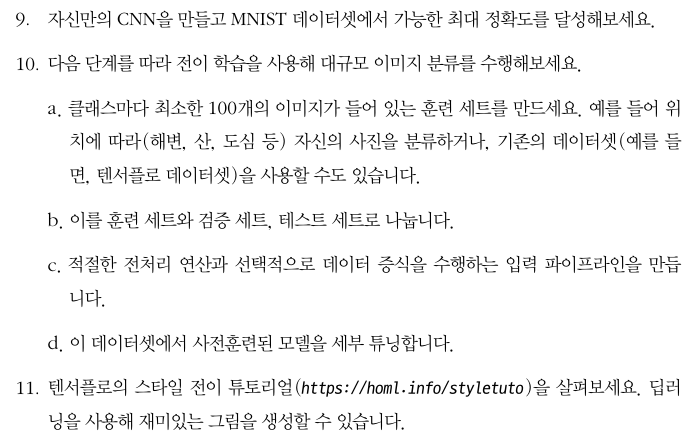

연습문제 9

2개의 합성곱 층, 1개의 풀링 층, 25% 드롭아웃, 그리고 은닉층, 다시 50%의 드롭아웃, 출력층으로 구성됨

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train_full.shape

11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28)

In [9]:
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis] #컬러 채널 추가(그레이 스케일)
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [10]:
X_train.shape

(55000, 28, 28, 1)

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"), #3*3크기의 필터 32개, 제로패딩 사용
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
             metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10,
         validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 74s 43ms/step - loss: 0.1989 - accuracy: 0.9393 - val_loss: 0.0462 - val_accuracy: 0.9882
Epoch 2/10
1719/1719 [==============================] - 75s 44ms/step - loss: 0.0792 - accuracy: 0.9760 - val_loss: 0.0448 - val_accuracy: 0.9872
Epoch 3/10
1719/1719 [==============================] - 76s 44ms/step - loss: 0.0621 - accuracy: 0.9811 - val_loss: 0.0357 - val_accuracy: 0.9910
Epoch 4/10
1719/1719 [==============================] - 75s 44ms/step - loss: 0.0514 - accuracy: 0.9843 - val_loss: 0.0356 - val_accuracy: 0.9900
Epoch 5/10
1719/1719 [==============================] - 75s 44ms/step - loss: 0.0401 - accuracy: 0.9871 - val_loss: 0.0372 - val_accuracy: 0.9910
Epoch 6/10
1719/1719 [==============================] - 74s 43ms/step - loss: 0.0353 - accuracy: 0.9885 - val_loss: 0.0396 - val_accuracy: 0.9912
Epoch 7/10
1719/1719 [==============================] - 76s 44ms/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.0316 -

[0.02930488809943199, 0.9916999936103821]

99.16%의 정확도

더 높이고 싶다면 이미지 변환, 배치 정규화, 1 사이클 학습 스케쥴 등을 사용할 수 있다.

연습 문제 11

https://www.tensorflow.org/tutorials/generative/style_transfer
    
확인하기